# Chapter 8 - Tree Based Methods

[8.1 The Basics of Decision Trees](#8.1-The-Basics-of-Decision-Trees)
> [8.1.1 Regression Trees](#8.1.1-Regression-Trees)<br>
> [8.1.2 Classification Trees](#8.1.2-Classification-Trees)<br>

[8.2 Bagging, Random Forests, Boosting](#8.2-Bagging,-Random-Forests,-Boosting)
> [8.2.1 Bagging](#8.2.1-Bagging)<br>
> [8.2.2 Random Forests](#8.2.2-Random-Forests)<br>
> [8.2.3 Boosting](#8.2.3-Boosting)

[8.3 Lab: Decision Trees](#8.3-Lab:-Decision-Trees)
> [8.3.1 Fitting Classification Trees](#8.3.1-Fitting-Classification-Trees)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score

from itertools import groupby

import warnings

from classification_helper import print_classification_statistics, plot_ROC

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# find the location of graphviz so dot.exe is in the PATH
import os
common_path = os.path.commonpath([path for path in os.environ["PATH"].split(';') if 'Anaconda' in path])
dot_path = os.path.join(common_path, 'Library', 'bin', 'graphviz')
os.environ["PATH"] += os.pathsep + dot_path

In [3]:
# This function creates images of tree models using pydot
def plot_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, 
                    feature_names=features, class_names=classn, 
                    filled=filled,
                    precision=2)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
    return Image(graph.create_png())

In [4]:
df_hitters = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()
df_hitters.index.name = 'Player'
df_hitters.index = df_hitters.index.map(lambda x: x.replace('-', '', 1))
df_hitters["League"] = df_hitters["League"].astype('category')
df_hitters["Division"] = df_hitters["Division"].astype('category')
df_hitters["NewLeague"] = df_hitters["NewLeague"].astype('category')
df_hitters.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N


## 8.1 The Basics of Decision Trees

### 8.1.1 Regression Trees

In [5]:
X = df_hitters[['Years', 'Hits']]
y = np.log(df_hitters.Salary)

In [6]:
# we can also use the option max_leaf_nodes=3 alone
regressionTree = DecisionTreeRegressor(max_depth=2, min_impurity_decrease=0.05)
regressionTree = regressionTree.fit(X, y)

#### FIGURE 8.1

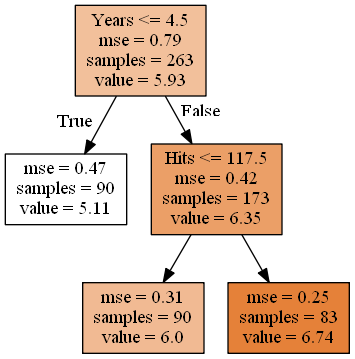

In [7]:
plot_tree(regressionTree, ['Years', 'Hits'])

#### FIGURE 8.2

In [8]:
lines = []
for node, feature in enumerate(regressionTree.tree_.feature):
    if feature != -2: # node
        lines.append((feature, regressionTree.tree_.threshold[node]))

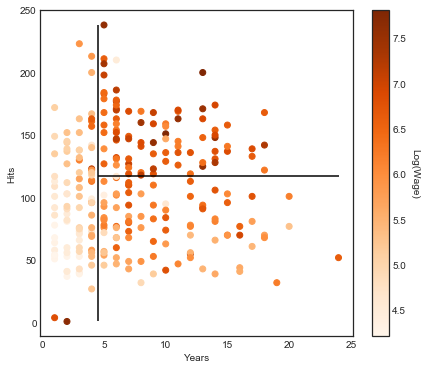

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
# the color indicates the value
sc = ax.scatter(X.Years, X.Hits, c=y, cmap='Oranges')
ax.set_ylabel('Hits')
ax.set_xlabel('Years')
# this algorithm doesn't really work for other cases...
last_threshold = None
for feature, threshold in lines:
    if feature == 0:
        if not last_threshold:
            ax.vlines(threshold, ymin=X.iloc[:,0].min(), ymax=X.iloc[:,1].max())
        else:
            ax.vlines(threshold, ymin=X.iloc[:,0].min(), ymax=last_threshold)
    else:
        if not last_threshold:
            ax.hlines(threshold, xmin=X.iloc[:,1].min(), xmax=X.iloc[:,0].max())
        else:
            ax.hlines(threshold, xmin=last_threshold, xmax=X.iloc[:,0].max())
    last_threshold = threshold
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Log(Wage)', rotation=-90, va="bottom");

#### Tree Pruning

In [10]:
# try to emulate tree prunning using the maximum number of leaf nodes
feature_names = ['Years', 'RBI', 'Hits', 'PutOuts', 'Walks', 'Runs']
X = df_hitters[feature_names]
y = np.log(df_hitters.Salary)

In [11]:
scores = []
max_leafs_arr = range(2, 50)
for max_leafs in max_leafs_arr:
    regressionTree = DecisionTreeRegressor(max_leaf_nodes=max_leafs)
    sc = cross_val_score(regressionTree, X, y, cv=10, scoring="neg_mean_squared_error")
    scores.append((-sc.mean(), sc.std()))
scores = np.array(scores)

The best tree has 7 leafs.


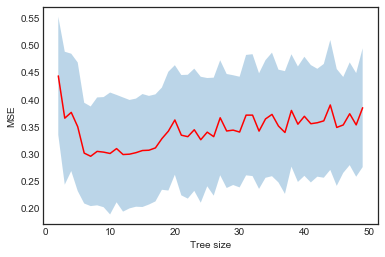

In [12]:
plt.plot(max_leafs_arr, scores[:,0], 'r')
plt.fill_between(max_leafs_arr, scores[:,0]+scores[:,1], scores[:,0]-scores[:,1], alpha=0.3)
plt.xlabel('Tree size')
plt.ylabel('MSE')
best_min_leafs = max_leafs_arr[np.argmin(scores[:,0])]
print(f"The best tree has {best_min_leafs} leafs.")

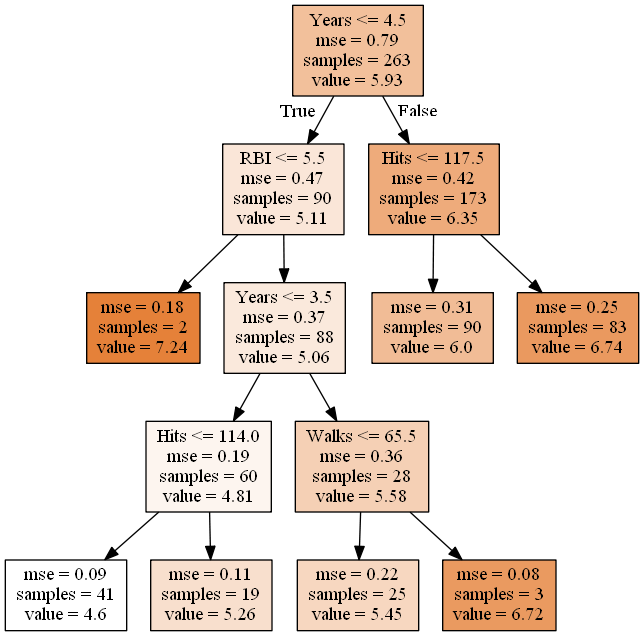

In [13]:
plot_tree(DecisionTreeRegressor(max_leaf_nodes=best_min_leafs).fit(X,y), feature_names)

#### The results are different than the book

### 8.1.2 Classification Trees

In [14]:
df_heart = pd.read_csv('Data/Heart.csv', index_col=0).dropna()
for cat_col in ['ChestPain', 'Thal', 'AHD']:
    df_heart[cat_col] = df_heart[cat_col].astype('category')
    print(f'{cat_col}: {df_heart[cat_col].cat.categories.values}')

ChestPain: ['asymptomatic' 'nonanginal' 'nontypical' 'typical']
Thal: ['fixed' 'normal' 'reversable']
AHD: ['No' 'Yes']


In [15]:
df_heart.head(3)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


In [16]:
X = pd.get_dummies(df_heart[df_heart.columns.difference(['AHD'])], drop_first=True)
y = pd.get_dummies(df_heart.AHD, drop_first=True)

In [17]:
X.head(3)

,Age,Ca,Chol,ExAng,Fbs,MaxHR,Oldpeak,RestBP,RestECG,Sex,Slope,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_normal,Thal_reversable
1,63,0.0,233,0,1,150,2.3,145,2,1,3,0,0,1,0,0
2,67,3.0,286,1,0,108,1.5,160,2,1,2,0,0,0,1,0
3,67,2.0,229,1,0,129,2.6,120,2,1,2,0,0,0,0,1


In [18]:
clf = DecisionTreeClassifier(max_depth=6, min_impurity_decrease=0.01)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.01, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

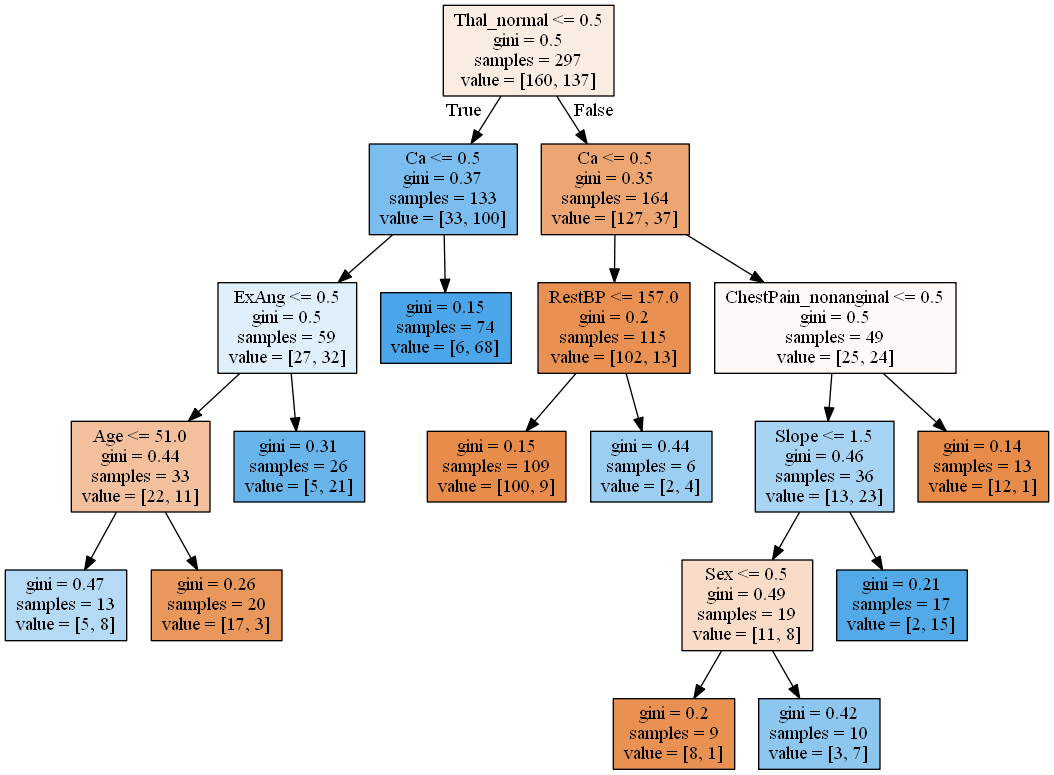

In [19]:
# unprunned tree
plot_tree(clf, X.columns)

In [20]:
scores = []
max_leafs_arr = range(2, 50)
for max_leafs in max_leafs_arr:
    regressionTree = DecisionTreeClassifier(max_leaf_nodes=max_leafs)
    sc = cross_val_score(regressionTree, X, y, cv=10)
    scores.append((sc.mean(), sc.std()))
scores = np.array(scores)

The best tree has 4 leafs.


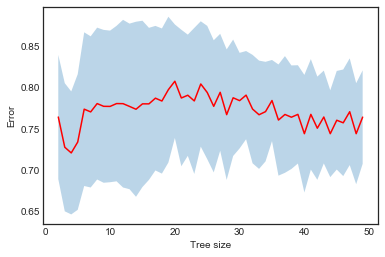

In [21]:
plt.plot(max_leafs_arr, scores[:,0], 'r')
plt.fill_between(max_leafs_arr, scores[:,0]+scores[:,1], scores[:,0]-scores[:,1], alpha=0.3)
plt.xlabel('Tree size')
plt.ylabel('Error')
best_min_leafs = max_leafs_arr[np.argmin(scores[:,0])]
print(f"The best tree has {best_min_leafs} leafs.")

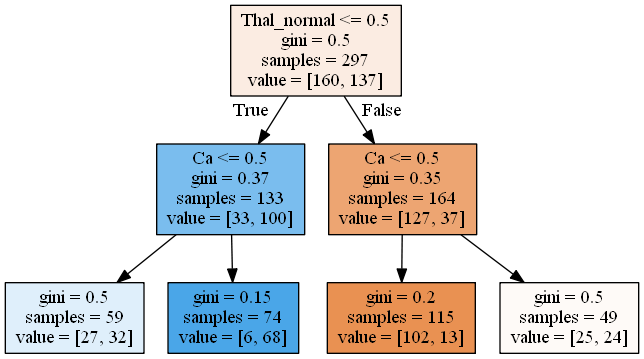

In [22]:
plot_tree(DecisionTreeClassifier(max_leaf_nodes=best_min_leafs).fit(X,y), X.columns)

#### Again, the best tree is different from the book

## 8.2 Bagging, Random Forests, Boosting

### 8.2.1 Bagging

In [23]:
X = pd.get_dummies(df_heart[df_heart.columns.difference(['AHD'])], drop_first=True)
y = pd.get_dummies(df_heart.AHD, drop_first=True).values.ravel()

In [24]:
scores_OOB_bagging = []
scores_bagging = []
trees_number = range(1, 100, 5)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for B in trees_number:
        clf_bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=B, oob_score=True)
        clf_bag.fit(X, y)
        scores_OOB_bagging.append(1-clf_bag.oob_score_)
        # this is computationally expensive, so better use OOB
        sc = 1-cross_val_score(clf_bag, X, y, cv=2)
        scores_bagging.append(sc.mean())
scores_OOB_bagging = np.array(scores_OOB_bagging)
scores_bagging = np.array(scores_bagging)

#### FIGURE 8.8

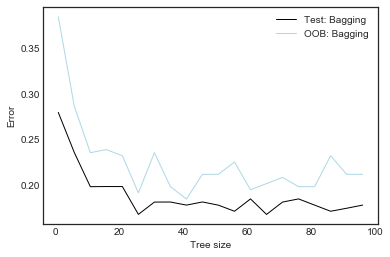

In [25]:
plt.plot(trees_number, scores_bagging, 'black', label='Test: Bagging', lw=1)
plt.plot(trees_number, scores_OOB_bagging, 'lightblue', label='OOB: Bagging', lw=1)
plt.legend()
plt.xlabel('Tree size')
plt.ylabel('Error');

#### FIGURE 8.9

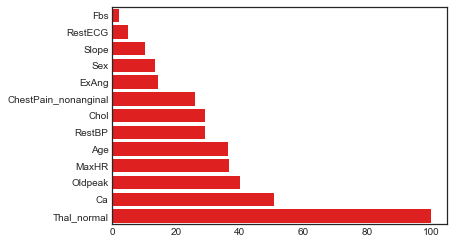

In [26]:
feature_importances = np.sum(est.feature_importances_ for est in clf_bag.estimators_)/clf_bag.n_estimators

# sum categorical features that belong together
original_cols = df_heart.columns.difference(['AHD'])
# get only categorical features from the original ones
cat_features = [col for col in original_cols if isinstance(df_heart[col].dtype, pd.api.types.CategoricalDtype)]
# get features that have been expanded from the categorical ones
rep_feat = [col for col in X.columns if any(col.startswith(cat) for cat in cat_features)]
# return the position of the categorical feature that s belongs to
def groupby_cat_feature(s):
    for cat_feature in cat_features:
        if cat_feature in s:
            return cat_features.index(cat_feature)
    return -1
# get the indices of the categorical features that belong together
groups_idx = [[X.columns.tolist().index(feat) for feat in group] for _, group in groupby(rep_feat, key=groupby_cat_feature)]
# index of first feature in each group
first_idx = [val for (val, *_) in groups_idx]
# indices of other
other_idx = [item for sublist in [val for (_, *val) in groups_idx] for item in sublist]
# add those values
feature_importances_clean = feature_importances.copy()
feature_importances_clean[first_idx] = [np.sum(feature_importances[group_i]) for group_i in groups_idx]
feature_importances_clean = np.delete(feature_importances_clean, other_idx)
cols_clean = np.delete(X.columns, other_idx)

sort_idx = np.argsort(feature_importances_clean)
sns.barplot(feature_importances_clean[sort_idx]/np.max(feature_importances_clean)*100, cols_clean[sort_idx], color='r');

### 8.2.2 Random Forests

In [27]:
X = pd.get_dummies(df_heart[df_heart.columns.difference(['AHD'])], drop_first=True)
y = pd.get_dummies(df_heart.AHD, drop_first=True).values.ravel()

In [28]:
scores_p_rnd_forest = []
scores_p2_rnd_forest = []
scores_sqrt_p_rnd_forest = []
trees_number = range(1, 200, 10)
p = len(X.columns)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for B in trees_number:
        clf_p = RandomForestClassifier(n_estimators=B, max_features=p,  oob_score=True, n_jobs=-1)
        clf_p.fit(X, y)
        scores_p_rnd_forest.append(1-clf_p.oob_score_)
        
        clf_p_2 = RandomForestClassifier(n_estimators=B, max_features=p//2, oob_score=True, n_jobs=-1)
        clf_p_2.fit(X, y)
        scores_p2_rnd_forest.append(1-clf_p_2.oob_score_)
        
        clf_sqrt_p = RandomForestClassifier(n_estimators=B, max_features=int(np.sqrt(p)), oob_score=True, n_jobs=-1)
        clf_sqrt_p.fit(X, y)
        scores_sqrt_p_rnd_forest.append(1-clf_sqrt_p.oob_score_)
scores_p_rnd_forest = np.array(scores_p_rnd_forest)
scores_p2_rnd_forest = np.array(scores_p2_rnd_forest)
scores_sqrt_p_rnd_forest = np.array(scores_sqrt_p_rnd_forest)

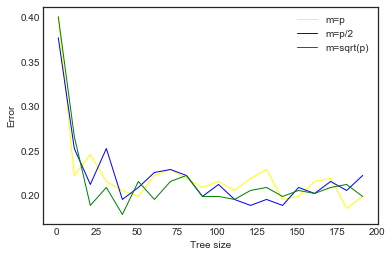

In [29]:
plt.plot(trees_number, scores_p_rnd_forest, 'yellow', label='m=p', lw=1)
plt.plot(trees_number, scores_p2_rnd_forest, 'blue', label='m=p/2', lw=1)
plt.plot(trees_number, scores_sqrt_p_rnd_forest, 'green', label='m=sqrt(p)', lw=1)
plt.legend()
plt.xlabel('Tree size')
plt.ylabel('Error');

### 8.2.3 Boosting

In [30]:
X = pd.get_dummies(df_heart[df_heart.columns.difference(['AHD'])], drop_first=True)
y = pd.get_dummies(df_heart.AHD, drop_first=True).values.ravel()

In [31]:
scores_boost_1 = []
scores_boost_2 = []
scores_sqrt_p_rnd_forest = []
trees_number = range(1, 2000, 100)
p = len(X.columns)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for B in trees_number:
        clf_1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=B, learning_rate=0.01)
        sc = cross_val_score(clf_1, X, y)
        scores_boost_1.append(1-sc.mean())
        
        clf_2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=B, learning_rate=0.01)
        sc = cross_val_score(clf_2, X, y)
        scores_boost_2.append(1-sc.mean())
        
        clf_sqrt_p = RandomForestClassifier(n_estimators=B, max_features=int(np.sqrt(p)), oob_score=True, n_jobs=-1)
        clf_sqrt_p.fit(X, y)
        scores_sqrt_p_rnd_forest.append(1-clf_sqrt_p.oob_score_)
scores_p_rnd_forest = np.array(scores_p_rnd_forest)
scores_p2_rnd_forest = np.array(scores_p2_rnd_forest)
scores_sqrt_p_rnd_forest = np.array(scores_sqrt_p_rnd_forest)

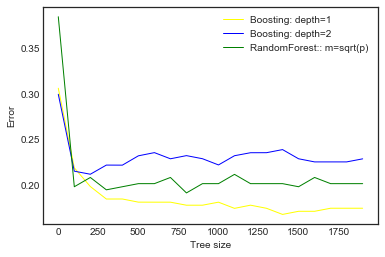

In [32]:
plt.plot(trees_number, scores_boost_1, 'yellow', label='Boosting: depth=1', lw=1)
plt.plot(trees_number, scores_boost_2, 'blue', label='Boosting: depth=2', lw=1)
plt.plot(trees_number, scores_sqrt_p_rnd_forest, 'green', label='RandomForest:: m=sqrt(p)', lw=1)
plt.legend()
plt.xlabel('Tree size')
plt.ylabel('Error');

## 8.3 Lab: Decision Trees

### 8.3.1 Fitting Classification Trees

In [33]:
df_carseats = pd.read_csv('Data/Carseats.csv', index_col=0).dropna()
# transform strings into categories
for col in df_carseats.columns:
    if pd.api.types.is_object_dtype(df_carseats[col].dtype):
        df_carseats[col] = df_carseats[col].astype('category')
        print(f'{col}: {df_carseats[col].cat.categories.values}')
df_carseats.head(3)

ShelveLoc: ['Bad' 'Good' 'Medium']
Urban: ['No' 'Yes']
US: ['No' 'Yes']


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes


In [34]:
df_carseats['High'] = np.where(df_carseats.Sales > 8, 'Yes', 'No')
df_carseats.High = df_carseats.High.astype('category')
df_carseats.head(3)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,Yes


In [35]:
y = df_carseats.High.cat.codes
X = df_carseats[df_carseats.columns.difference(['Sales', 'High'])]
X = pd.get_dummies(X, drop_first=True)
X.head()

,Advertising,Age,CompPrice,Education,Income,Population,Price,ShelveLoc_Good,ShelveLoc_Medium,US_Yes,Urban_Yes
1,11,42,138,17,73,276,120,0,0,1,1
2,16,65,111,10,48,260,83,1,0,1,1
3,10,59,113,12,35,269,80,0,1,1,1
4,4,55,117,14,100,466,97,0,1,1,1
5,3,38,141,13,64,340,128,0,0,0,1


In [36]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

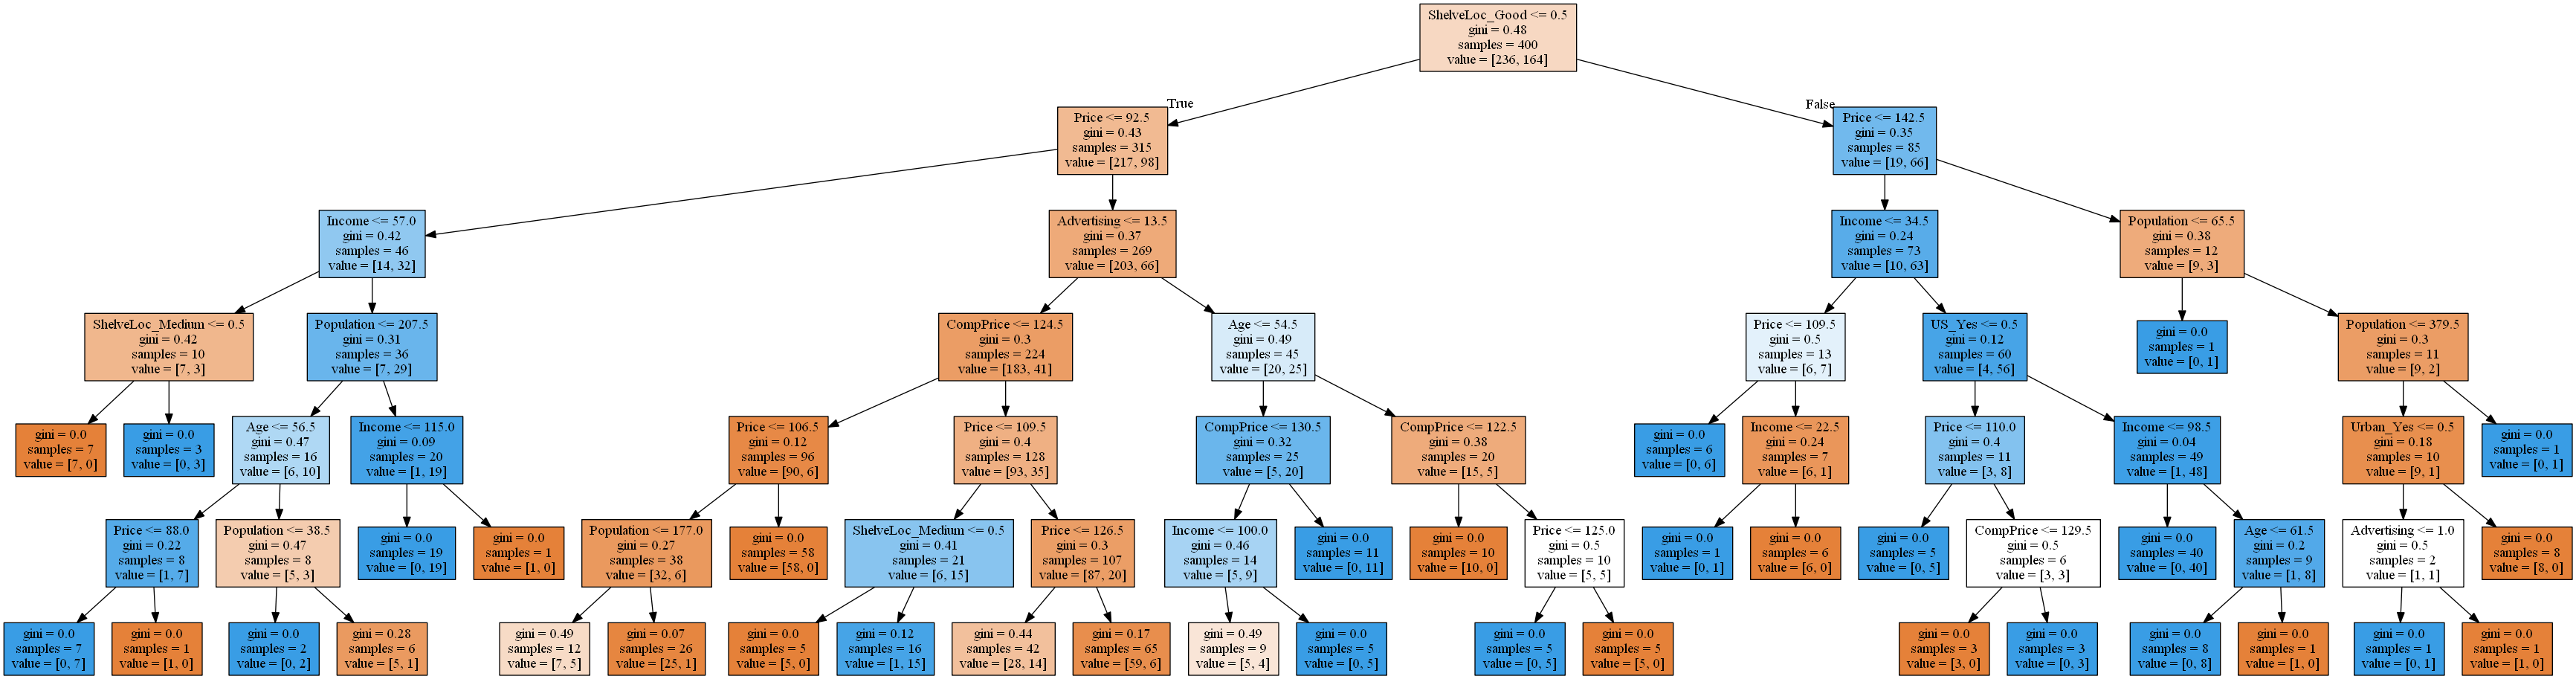

In [37]:
plot_tree(clf, X.columns)

Classification Report:
             precision    recall  f1-score   support

          0      0.883     0.996     0.936       236
          1      0.993     0.811     0.893       164

avg / total      0.928     0.920     0.918       400

Confusion Matrix:
           Predicted          
                True     False
Real True   0.995763  0.004237
     False  0.189024  0.810976



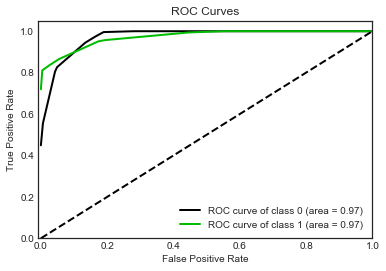

In [38]:
print_classification_statistics(clf, X, y)
plot_ROC(clf, X, y, 'Tree')

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

Classification Report:
             precision    recall  f1-score   support

          0      0.677     0.754     0.714       114
          1      0.616     0.523     0.566        86

avg / total      0.651     0.655     0.650       200

Confusion Matrix:
           Predicted          
                True     False
Real True   0.754386  0.245614
     False  0.476744  0.523256

Accuracy:  65.5 %


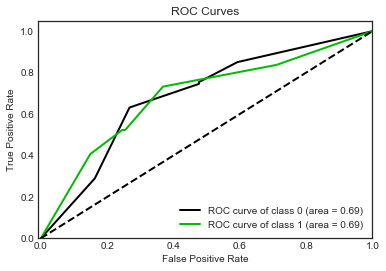

In [40]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)
print_classification_statistics(clf, X_test, y_test)
plot_ROC(clf, X_test, y_test, 'Tree')
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred)*100, '%')

#### Prune the tree by maximum number of leaves

In [41]:
scores = []
max_leafs_arr = range(2, 50)
for max_leafs in max_leafs_arr:
    regressionTree = DecisionTreeClassifier(max_leaf_nodes=max_leafs)
    sc = cross_val_score(regressionTree, X, y, cv=10)
    scores.append((sc.mean(), sc.std()))
scores = np.array(scores)

The best tree has 4 leafs.


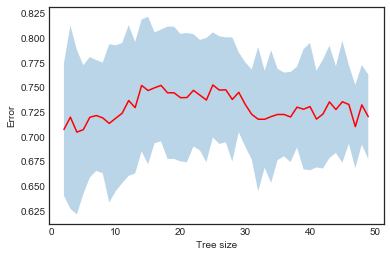

In [42]:
plt.plot(max_leafs_arr, scores[:,0], 'r')
plt.fill_between(max_leafs_arr, scores[:,0]+scores[:,1], scores[:,0]-scores[:,1], alpha=0.3)
plt.xlabel('Tree size')
plt.ylabel('Error')
best_min_leafs = max_leafs_arr[np.argmin(scores[:,0])]
print(f"The best tree has {best_min_leafs} leafs.")

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [82]:
# Set up possible values of parameters to optimize over
p_grid = {"max_leaf_nodes": list(range(2, 50)),
          'min_impurity_decrease': np.linspace(0, 0.02, 5)}

clf = DecisionTreeClassifier(min_samples_leaf=5)

# Parameter search and scoring
grid_search = GridSearchCV(estimator=clf, param_grid=p_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

Classification Report:
             precision    recall  f1-score   support

          0      0.772     0.868     0.817       121
          1      0.750     0.608     0.671        79

avg / total      0.763     0.765     0.760       200

Confusion Matrix:
           Predicted          
                True     False
Real True   0.867769  0.132231
     False  0.392405  0.607595

Accuracy:  76.5 %


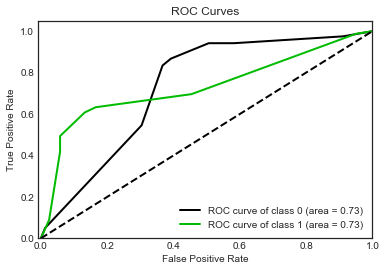

In [83]:
print_classification_statistics(grid_search, X_test, y_test)
plot_ROC(grid_search, X_test, y_test, 'Tree')
# we also get a higher accuracy than the pure tree
y_pred = grid_search.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred)*100, '%')

In [84]:
grid_search.best_params_

{'max_leaf_nodes': 8, 'min_impurity_decrease': 0.0050000000000000001}

In [85]:
df_grid = pd.DataFrame({k.replace('param_', ''): v for k, v in grid_search.cv_results_.items() 
                        if ( ('param_' in k) or (k in ['mean_test_score', 'std_test_score']) )})
df_grid.head()

,max_leaf_nodes,min_impurity_decrease,mean_test_score,std_test_score
0,2,0,0.675966,0.057861
1,2,0.005,0.675966,0.057861
2,2,0.01,0.675966,0.057861
3,2,0.015,0.675966,0.057861
4,2,0.02,0.675966,0.057861


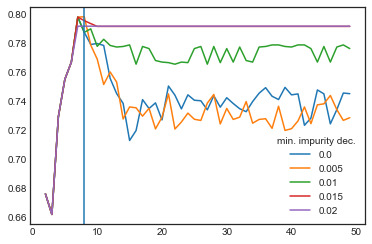

In [86]:
for imp_dec in p_grid['min_impurity_decrease']:
    plt.plot(p_grid['max_leaf_nodes'], df_grid.mean_test_score[df_grid.min_impurity_decrease == imp_dec], label=imp_dec)
plt.axvline(grid_search.best_params_['max_leaf_nodes']);
plt.legend(title='min. impurity dec.');

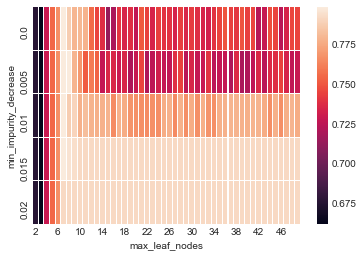

In [87]:
heatmap_data = df_grid.pivot("min_impurity_decrease", "max_leaf_nodes", "mean_test_score")
sns.heatmap(heatmap_data, linewidths=.01, xticklabels=4);

### 8.3.2 Fitting Regression Trees